In [ ]:
import pandas as pd

In [ ]:
df_co2 = pd.read_csv('carbon_emission_corpus.csv')
df_env = pd.read_csv('environment_corpus.csv')
df_climate = pd.read_csv('climate_change_corpus.csv')

In [ ]:
# Make a list
corpus = df_env.iloc[:,1].tolist()
corpus += df_co2.iloc[:,1].values.tolist()
corpus += df_climate.iloc[:,1].values.tolist()

# Remove duplicates
corpus = list(set(corpus))

In [ ]:
import csv

with open('corpus_list.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(corpus)

In [ ]:
len(corpus)

# 1. Clean corpus

In [3]:
import pandas as pd
import nltk
import csv

In [4]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jasmine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jasmine\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jasmine\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasmine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
with open('corpus_list.csv', 'r') as f:
    reader = csv.reader(f)
    corpus = list(reader)
    
corpus = corpus[0]
corpus.append('carbon')

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
corpus = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in corpus]

# 2. Import INDC

In [8]:
df_indc = pd.read_csv('ndc_sdg.csv')
list_of_indc = df_indc['Indc text'].tolist()
list_of_indc = [string.lower() for string in list_of_indc]
list_of_indc = list(dict.fromkeys(list_of_indc))

In [9]:
df_indc = pd.read_excel('CW_WRI_NDC_SDGs_Linkages_31102017.xlsx', header=3)
df_indc['INDC_text'] = df_indc['INDC_text'].astype('str')
list_of_indc = df_indc['INDC_text'].tolist()
list_of_indc = list(dict.fromkeys(list_of_indc))
list_of_indc = [string.lower().strip(' \n') for string in list_of_indc]

## Form dictionary of tokens
Key word: value count

In [10]:
import re
import string
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
clean_list_of_indc = []
translator = str.maketrans('', '', string.punctuation)
for string in list_of_indc:
    clean_string = string.replace("<.*?>", "")
    clean_string = re.sub(r'\d+', '', string)
    clean_string = clean_string.translate(translator).strip()
    clean_string = clean_string.translate(translator).strip('\n')
    
    tokens = word_tokenize(clean_string)
    result = [i for i in tokens if not i in stop_words]
    result = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in result]
    clean_list_of_indc += result

In [11]:
filter_list_of_words = [i for i in clean_list_of_indc if i in corpus]

In [12]:
from collections import Counter
filter_dict_of_words = dict(Counter(filter_list_of_words).most_common())

In [ ]:
filter_dict_of_words

In [13]:
df_indc = df_indc[['Country', 'INDC_text', 'Sector']]

In [14]:
filter_words = filter_dict_of_words.keys()
def count_score(string):
    score = 0
    for word in string.split():
        #print(word)
        if word.lower() in filter_words:
            score += filter_dict_of_words[word.lower()]
    return score
df_indc['Score'] = df_indc['INDC_text'].apply(count_score)

In [44]:
df_score = df_indc.groupby(['Country']).sum()
df_score.reset_index(level=0, inplace=True)

Specially for European Union

In [45]:
EU_INDC = 'The EU and its Member States are committed to a binding target of an at least 40% domestic reduction in greenhouse gas emissions by 2030 compared to 1990, to be fulfilled jointly, as set out in the conclusions by the European Council of October 2014.'
EU_INDC += 'Domestic legally-binding legislation already in place for the 2020 climate and energy package. The existing legislation for land use, land-use change and forestry (EU Decision 529/2013) is based on the existing accounting rules under the second commitment period of the Kyoto Protocol. Legislative proposals to implement the 2030 climate and energy framework, both in the emissions trading sector and in the non-traded sector, to be submitted by the European Commission to the Council and European Parliament in 2015-2016 on the basis of the general political directions by the European Council, taking into account environmental integrity.'
EU_INDC += 'The target represents a significant progression beyond its current undertaking of a 20% emission reduction commitment by 2020 compared to 1990 (which includes the use of offsets). It is in line with the EU objective, in the context of necessary reductions according to the IPCC by developed countries as a group, to reduce its emissions by 80-95% by 2050 compared to 1990. Furthermore, it is consistent with the need for at least halving global emissions by 2050 compared to 1990. The EU and its Member States have already reduced their emissions by around 19% on 1990 levels while GDP has grown by more than 44% over the same period. As a result, average per capita emissions across the EU and its Member States have fallen from 12 tonnes CO2-eq. in 1990 to 9 tonnes CO2-eq. in 2012 and are projected to fall to around 6 tonnes CO2-eq. in 2030. The emissions in the EU and its Member States peaked in 1979.'

EU_Score = count_score(EU_INDC)*5
df_score = df_score.append({'Country': 'European Union', 'Score': EU_Score}, ignore_index=True)

df_score['Normalised'] = (df_score['Score'] - df_score['Score'].min()) / (df_score['Score'].max() - df_score['Score'].min())

In [48]:
df_score_filtered = df_score[df_score['Country'].isin(['Brazil', 'China', 'Japan', 'India', 'France', 'Italy', 'Canada', 'UK', 'United States of America', 'Germany', 'European Union'])]
df_score_filtered.to_csv('score_list.csv')

# 3. Create WordCloud

In [66]:
df_filter = pd.DataFrame()
df_filter['words'] = filter_dict_of_words.keys()
df_filter['count'] = filter_dict_of_words.values()
df_filter.to_csv('word_cloud_list.csv', index=False, sep=';')

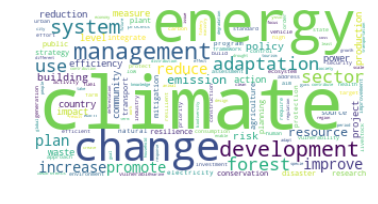

In [65]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import numpy as np
import urllib
import requests
import matplotlib.pyplot as plt

mask = np.array(Image.open("worldmap.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.fit_words(filter_dict_of_words)

plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()